In [2269]:
# Imports
import pandas as pd
from typing import Dict
import seaborn as sns

In [2270]:
# File paths
NEW_BUILD_CSV: str = "Data/Neubauwohnungen_Zürich.csv"
TAXABLE_INCOME_CSV: str = "Data/Vermögen_Stadt_zürich.csv"
EQUIVALIZED_INCOME_CSV: str = "Data/Haushaltsäquivalenz-Einkommen.csv"

In [2271]:
NEW_BUILD_COLMAP: Dict[str, str] = {
    # grouping
    "KreisLang": "district_name",
    "QuarLang": "quarter_name",
    "FuenfjahresPeriode_noDM": "five_year_period",
    # metrics
    "AnzRentner": "num_retirees",
    "AnzKinder": "num_children",
    "Wohnflaeche": "living_area",
    "AnzZimmerLevel2Cd_noDM": "num_rooms",
    "AnzWhgStat": "num_appartments",
    "AnzBestWir": "population_total",
    "MietwohnungSort": "num_rental_apartment",  
}

TAXABLE_INCOME_COLMAP: Dict[str, str] = {
    "KreisLang": "district_name",
    "StichtagDatJahr": "year",
    "SteuerEinkommen_p50": "taxable_income_p50",  # median taxable income (per year)
}

EQUIVALIZED_INCOME_COLMAP: Dict[str, str] = {
    "KreisLang": "district_name",
    "StichtagDatJahr": "year",
    "aequEK_p50": "equivalized_income_p50",  # median equivalized income (per year)
}

In [2272]:
def load_and_rename(csv_path: str, colmap: Dict[str, str]) -> pd.DataFrame:
    """Rename the CSV files"""
    df = pd.read_csv(csv_path)
    return df.rename(columns=colmap)

In [2273]:
def aggregate_new_build_by_district(csv_path: str = NEW_BUILD_CSV) -> pd.DataFrame:
    """
    Aggregate new-build apartments by district and five-year period.
    Logic matches the original:
      - sums of retirees, children, living area, rooms, appartements, population, rental_appartments
    """
    df = load_and_rename(csv_path, NEW_BUILD_COLMAP)

    aggregated = (
        df.groupby(["district_name", "five_year_period"])
          .agg(
              num_retirees=("num_retirees", "sum"),
              num_children=("num_children", "sum"),
              living_area=("living_area", "sum"),
              num_rooms=("num_rooms", "sum"),
              num_dwellings=("num_appartments", "sum"),
              population_total=("population_total", "sum"),
              rental_dwellings=("num_rental_apartment", lambda x: (x == 1).sum()),
          )
          .reset_index()
    )

    return aggregated

In [2274]:
def aggregate_new_build_by_quarter(csv_path: str = NEW_BUILD_CSV) -> pd.DataFrame:
    """
    Aggregate new-build apartments by quarter and five-year period.
    Same metrics and logic as the district-level aggregation.
    """
    df = load_and_rename(csv_path, NEW_BUILD_COLMAP)

    aggregated = (
        df.groupby(["quarter_name", "five_year_period"])
          .agg(
              num_retirees=("num_retirees", "sum"),
              num_children=("num_children", "sum"),
              living_area=("living_area", "sum"),
              num_rooms=("num_rooms", "sum"),
              num_dwellings=("num_appartments", "sum"),
              population_total=("population_total", "sum"),
              rental_dwellings=("num_rental_apartment", lambda s: (s == 1).sum()),
          )
          .reset_index()
    )

    return aggregated

In [2275]:
def aggregate_taxable_income_by_district(
    csv_path: str = TAXABLE_INCOME_CSV,
    year_min_inclusive: int = 2015,
    year_max_exclusive: int = 2019,
) -> pd.DataFrame:
    """
    Filter to years >= 2015, then group by district and compute the mean of the
    annual median taxable incomes (p50). Matches the original logic exactly.
    """
    df = load_and_rename(csv_path, TAXABLE_INCOME_COLMAP)
    df = df[(df["year"] >= year_min_inclusive) & (df["year"] < year_max_exclusive)]

    aggregated = (
        df.groupby("district_name")
          .agg(median_taxable_income=("taxable_income_p50", "mean"))
          .reset_index()
    )
    return aggregated

In [2276]:
def aggregate_equivalized_income_by_district(
    csv_path: str = EQUIVALIZED_INCOME_CSV,
    year_min_inclusive: int = 2015,
    year_max_exclusive: int = 2019,
) -> pd.DataFrame:
    """
    Filter to 2015 <= year < 2019, then group by district and compute the mean
    of the annual median equivalized incomes (p50). Matches original logic.
    """
    df = load_and_rename(csv_path, EQUIVALIZED_INCOME_COLMAP)
    df = df[(df["year"] >= year_min_inclusive) & (df["year"] < year_max_exclusive)]

    aggregated = (
        df.groupby("district_name")
          .agg(median_equivalized_income=("equivalized_income_p50", "mean"))
          .reset_index()
    )
    return aggregated

In [2277]:
def build_join_df(
    taxable_income_by_district: pd.DataFrame,
    new_build_by_district: pd.DataFrame,
    equivalized_income_by_district: pd.DataFrame,
) -> pd.DataFrame:
    """
    Reproduce the two-step LEFT/RIGHT merge from the original code:
      1) LEFT join taxable_income_by_district with new_build_by_district on district
      2) RIGHT join result with equivalized_income_by_district on district
    The final 'right' join ensures all districts from the taxable/new_build join
    are kept (as per original).
    """
    join_left = pd.merge(
        taxable_income_by_district,
        new_build_by_district,
        on="district_name",
        how="left",
    )

    joined = pd.merge(
        equivalized_income_by_district,
        join_left,
        on="district_name",
        how="right",
    )
    return joined


In [2278]:
# New-build aggregations (district & quarter)
new_build_by_quarter = aggregate_new_build_by_quarter()
new_build_by_district = aggregate_new_build_by_district()

# Income aggregations
taxable_income_by_district = aggregate_taxable_income_by_district()
equivalized_income_by_district = aggregate_equivalized_income_by_district()

# Final join
joined_df = build_join_df(
    taxable_income_by_district=taxable_income_by_district,
    new_build_by_district=new_build_by_district,
    equivalized_income_by_district=equivalized_income_by_district,
)

# View results
(new_build_by_quarter)
(taxable_income_by_district)
(equivalized_income_by_district)
(joined_df)

,district_name,median_equivalized_income,median_taxable_income,five_year_period,num_retirees,num_children,living_area,num_rooms,num_dwellings,population_total,rental_dwellings
0,Kreis 1,65.257037,77.108333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Kreis 10,56.927500,64.533333,2015–2019,138.0,521.0,81799.0,527.0,878.0,2051.0,120.0
2,Kreis 10,56.927500,64.533333,2020–2024,53.0,207.0,39621.0,425.0,446.0,963.0,88.0
3,Kreis 11,50.025250,52.108333,2015–2019,282.0,645.0,152628.0,1127.0,1694.0,3545.0,250.0
4,Kreis 11,50.025250,52.108333,2020–2024,309.0,989.0,193924.0,974.0,2389.0,5056.0,247.0
5,Kreis 12,39.501111,41.454167,2015–2019,402.0,1003.0,157775.0,516.0,1779.0,4327.0,154.0
6,Kreis 12,39.501111,41.454167,2020–2024,216.0,197.0,45411.0,402.0,582.0,1145.0,107.0
7,Kreis 2,58.973500,64.537500,2015–2019,218.0,921.0,133098.0,714.0,1412.0,3506.0,163.0
8,Kreis 2,58.973500,64.537500,2020–2024,178.0,824.0,137466.0,645.0,1623.0,3631.0,165.0
9,Kreis 3,51.827000,54.562500,2015–2019,192.0,425.0,62254.0,499.0,740.0,1722.0,129.0


In [2279]:
import pandas as pd
import numpy as np


data = pd.read_csv("Data/Wohnungen_Zürich.csv")
df_3 = data[["KreisLang", "KreisSort", "AnzZimmerLevel1Cd_noDM", "BauperiodeLevel1Lang","BauperiodeLevel1Sort","AnzWhgStat","Wohnflaeche"]].copy()

df_3 = df_3.groupby(["KreisLang", "KreisSort", "BauperiodeLevel1Lang", "BauperiodeLevel1Sort"]).aggregate({
    "AnzZimmerLevel1Cd_noDM": "sum",
    "AnzWhgStat": "sum",
    "Wohnflaeche": "sum"   
}).reset_index()

df_3 = df_3.rename(columns={
    "KreisLang": "district_name",
    "KreisSort": "district_sort",
    "BauperiodeLevel1Lang": "building_period",
    "BauperiodeLevel1Sort": "building_period_sort",
    "AnzZimmerLevel1Cd_noDM": "num_rooms",
    "AnzWhgStat": "num_appartments",
    "Wohnflaeche": "living_area"
})

df_3

,district_name,district_sort,building_period,building_period_sort,num_rooms,num_appartments,living_area
0,Kreis 1,1,1893 - 1899,2,1462,1740,100943
1,Kreis 1,1,1900 - 1909,3,643,304,32026
2,Kreis 1,1,1910 - 1919,4,744,485,50663
3,Kreis 1,1,1920 - 1929,5,457,195,18972
4,Kreis 1,1,1930 - 1939,6,1324,950,84719
...,...,...,...,...,...,...,...
174,Kreis 9,9,1990 - 1999,12,3268,12004,1005519
175,Kreis 9,9,2000 - 2009,13,4518,41649,4253272
176,Kreis 9,9,2010 - 2019,14,4020,49832,4524132
177,Kreis 9,9,2020 - 2029,15,860,6767,552768


C:\Users\livio\AppData\Local\Temp\ipykernel_22228\270626796.py:290: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


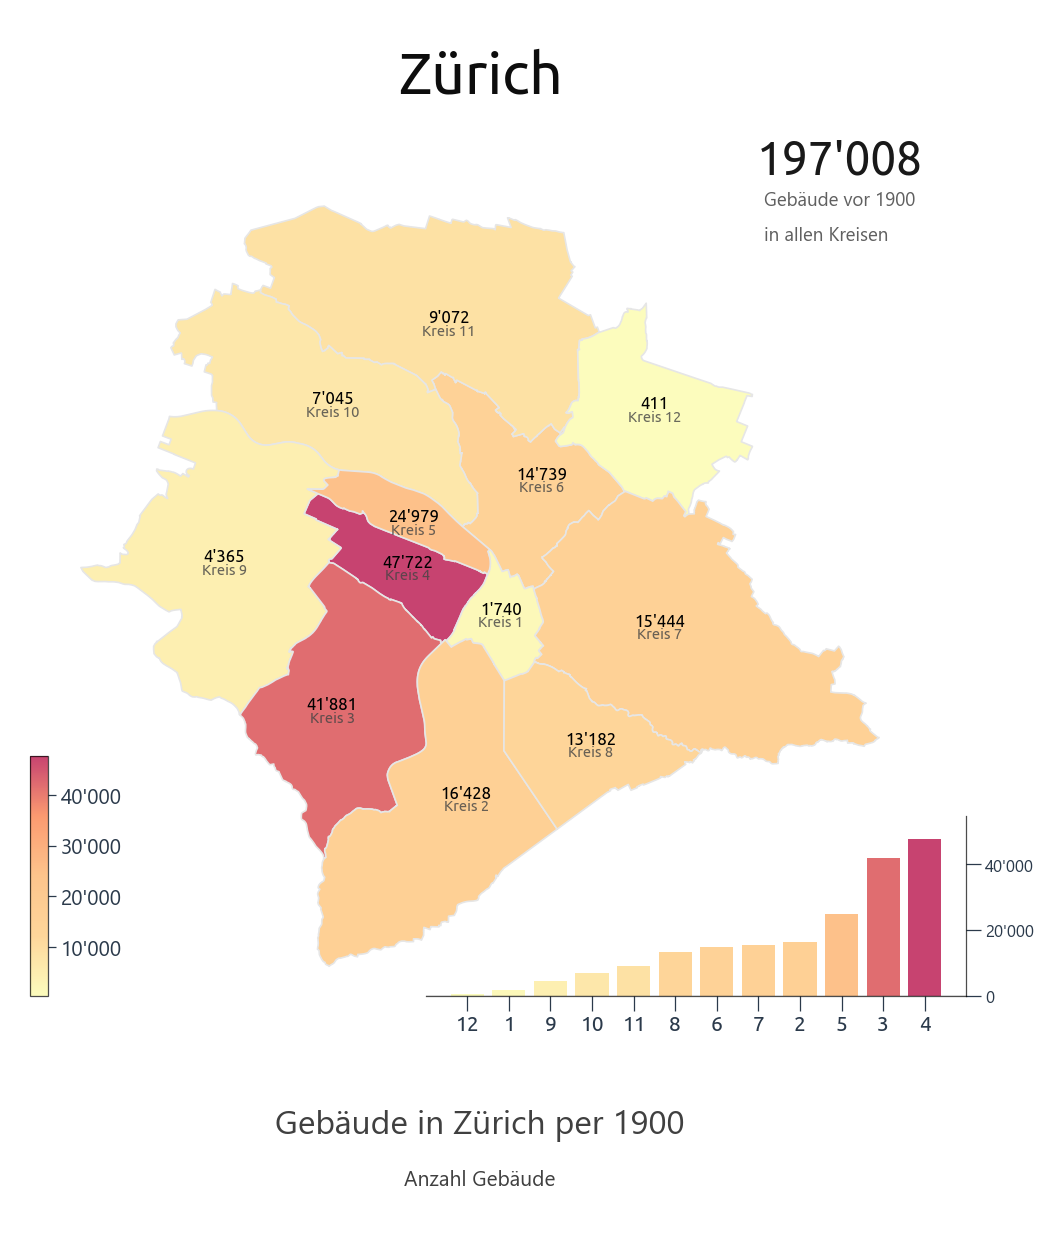

In [2280]:
# ==============================
# Imports
# ==============================
# Datenmanipulation
import numpy as np
import pandas as pd
import geopandas as gpd

# Visualisierung
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from highlight_text import fig_text

# Geospatial
import cartopy.crs as ccrs

# Colormaps
from pypalettes import create_cmap, load_cmap
from matplotlib.cm import ScalarMappable
from matplotlib import colors
import matplotlib.ticker as mticker

from pyfonts import load_google_font


# ==============================
# Grundeinstellungen
# ==============================
proj = ccrs.Mercator()

# Fonts
regular = load_google_font("Ubuntu")
bold = load_google_font("Ubuntu")

# Farben
BACKGROUND = "#ffffff"
text_color = "black"

# Colormap
cmap = create_cmap(
    colors=[
        "#FCFCBD",
        "#FED69A",
        "#FDC48C",
        "#FB9A70",
        "#C74370",
    ],
    cmap_type="continuous",
    name="Sunset3",
)


# ==============================
# Daten laden & vorbereiten
# ==============================
gdf = gpd.read_file("kreise_zuerich.geojson")

df_old = df_3[df_3["building_period_sort"] == 2][["district_name", "num_appartments", "district_sort"]]

gdf_old = gdf.merge(
    df_old,
    left_on="bezeichnung",
    right_on="district_name"
)


# ==============================
# Figure & Achse
# ==============================
fig, ax = plt.subplots(
    figsize=(6, 4),
    dpi=300,
    subplot_kw={"projection": proj}
)

fig.set_facecolor(BACKGROUND)
ax.set_facecolor(BACKGROUND)
ax.set_axis_off()


# ==============================
# Neuer grosser Titel "Zürich"
# ==============================
fig_text(
    x=0.5, y=0.96,                   # perfekt zentriert oben
    s="Zürich",
    color=text_color,
    fontsize=14,                    # gross
    fontproperties=bold,
    ha="center", va="top",
    alpha=0.95,
    zorder=20
)


# ==============================
# Karte plotten
# ==============================
map_ax = gdf_old.plot(
    ax=ax,
    column="num_appartments",
    cmap=cmap,
    linewidth=0.4,
    edgecolor="#e6e6e6",
    zorder=5
)


# ==============================
# Labels in den Kreisen
# ==============================
for _, row in gdf_old.iterrows():
    rep_point = row.geometry.representative_point()
    x, y = rep_point.x, rep_point.y

    name = row.get("district_name", row.get("bezeichnung"))
    num = f"{row['num_appartments']:,}".replace(",", "'")

    ax.text(
        x, y + 0.001,
        num,
        ha="center",
        va="center",
        fontproperties=bold,
        fontsize=4,
        color=text_color,
        zorder=10,
    )

    ax.text(
        x, y - 0.001,
        name,
        ha="center",
        va="center",
        fontproperties=regular,
        fontsize=3.5,
        color="#444444",
        alpha=0.8,
        zorder=10,
    )


# ==============================
# Titel & Untertitel
# ==============================
fig_text(
    x=0.5, y=0.075,
    s="Gebäude in Zürich per 1900",
    color=text_color, fontsize=8,
    ha="center", va="top",
    alpha=0.75,
    zorder=5
)

fig_text(
    x=0.5, y=0.025,
    s="Anzahl Gebäude",
    color=text_color, fontsize=5,
    ha="center", va="top",
    alpha=0.75,
    zorder=5
)


# ==============================
# Tausender-Formatter
# ==============================
def thousands_formatter(x, pos):
    if x == 0:
        return "0"
    return f"{int(x):,}".replace(",", "'")


# ==============================
# KPI oben rechts
# ==============================
total_buildings = int(gdf_old["num_appartments"].sum())
kpi_str = thousands_formatter(total_buildings, None)

KPI_X = 0.7
KPI_Y = 0.885
KPI_LINE_SPACING = 0.045

fig_text(
    x=KPI_X, y=KPI_Y,
    s=kpi_str,
    color=text_color,
    fontsize=11,
    fontproperties=bold,
    ha="center", va="top",
    alpha=0.9,
    zorder=6,
)

fig_text(
    x=KPI_X, y=KPI_Y - KPI_LINE_SPACING,
    s="Gebäude vor 1900\nin allen Kreisen",
    color="#444444",
    fontsize=4.5,
    ha="center", va="top",
    alpha=0.85,
    zorder=6,
)


# ==============================
# Colorbar
# ==============================
cax = fig.add_axes([0.25, 0.17, 0.01, 0.2])

vmin = gdf_old["num_appartments"].min()
vmax = gdf_old["num_appartments"].max()

sm = ScalarMappable(
    cmap=cmap,
    norm=colors.Normalize(vmin=vmin, vmax=vmax)
)
sm._A = []

cbar = fig.colorbar(
    sm,
    cax=cax,
    orientation="vertical",
    pad=0.02,
)

cbar.ax.tick_params(labelsize=5, width=0.3, length=2, pad=1)
cbar.outline.set_linewidth(0.3)
cbar.outline.set_alpha(0.7)
cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))


# ==============================
# Kleiner Barplot unten
# ==============================
bar_data = gdf_old.sort_values("num_appartments")

districts = bar_data["district_sort"].astype(str).values
values = bar_data["num_appartments"].values

norm = colors.Normalize(vmin=values.min(), vmax=values.max())
bar_colors = [cmap(norm(v)) for v in values]

bar_ax = fig.add_axes([0.47, 0.17, 0.3, 0.15])

bar_ax.set_facecolor("none")
bar_ax.patch.set_alpha(0.0)

bars = bar_ax.bar(
    x=range(len(values)),
    height=values,
    color=bar_colors,
    zorder=1
)

bar_ax.set_ylim(0, max(values) * 1.15)

bar_ax.axhline(0, linewidth=0.3, color="#444444", zorder=4)

xtick_fp = regular.copy()
xtick_fp.set_size(5)

bar_ax.set_xticks(range(len(values)))
bar_ax.set_xticklabels(
    districts,
    rotation=0,
    fontproperties=xtick_fp,
)

bar_ax.tick_params(axis="x", labelbottom=True, width=0.3, pad=1)

bar_ax.yaxis.tick_right()
bar_ax.tick_params(axis="y", labelsize=4, pad=1, width=0.3)
bar_ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))

for spine_name, spine in bar_ax.spines.items():
    if spine_name == "bottom":
        spine.set_linewidth(0.3)
        spine.set_alpha(0.7)
    elif spine_name == "right":
        spine.set_linewidth(0.3)
        spine.set_alpha(0.7)
    else:
        spine.set_visible(False)


# ==============================
# Layout
# ==============================
fig.tight_layout()
plt.show()


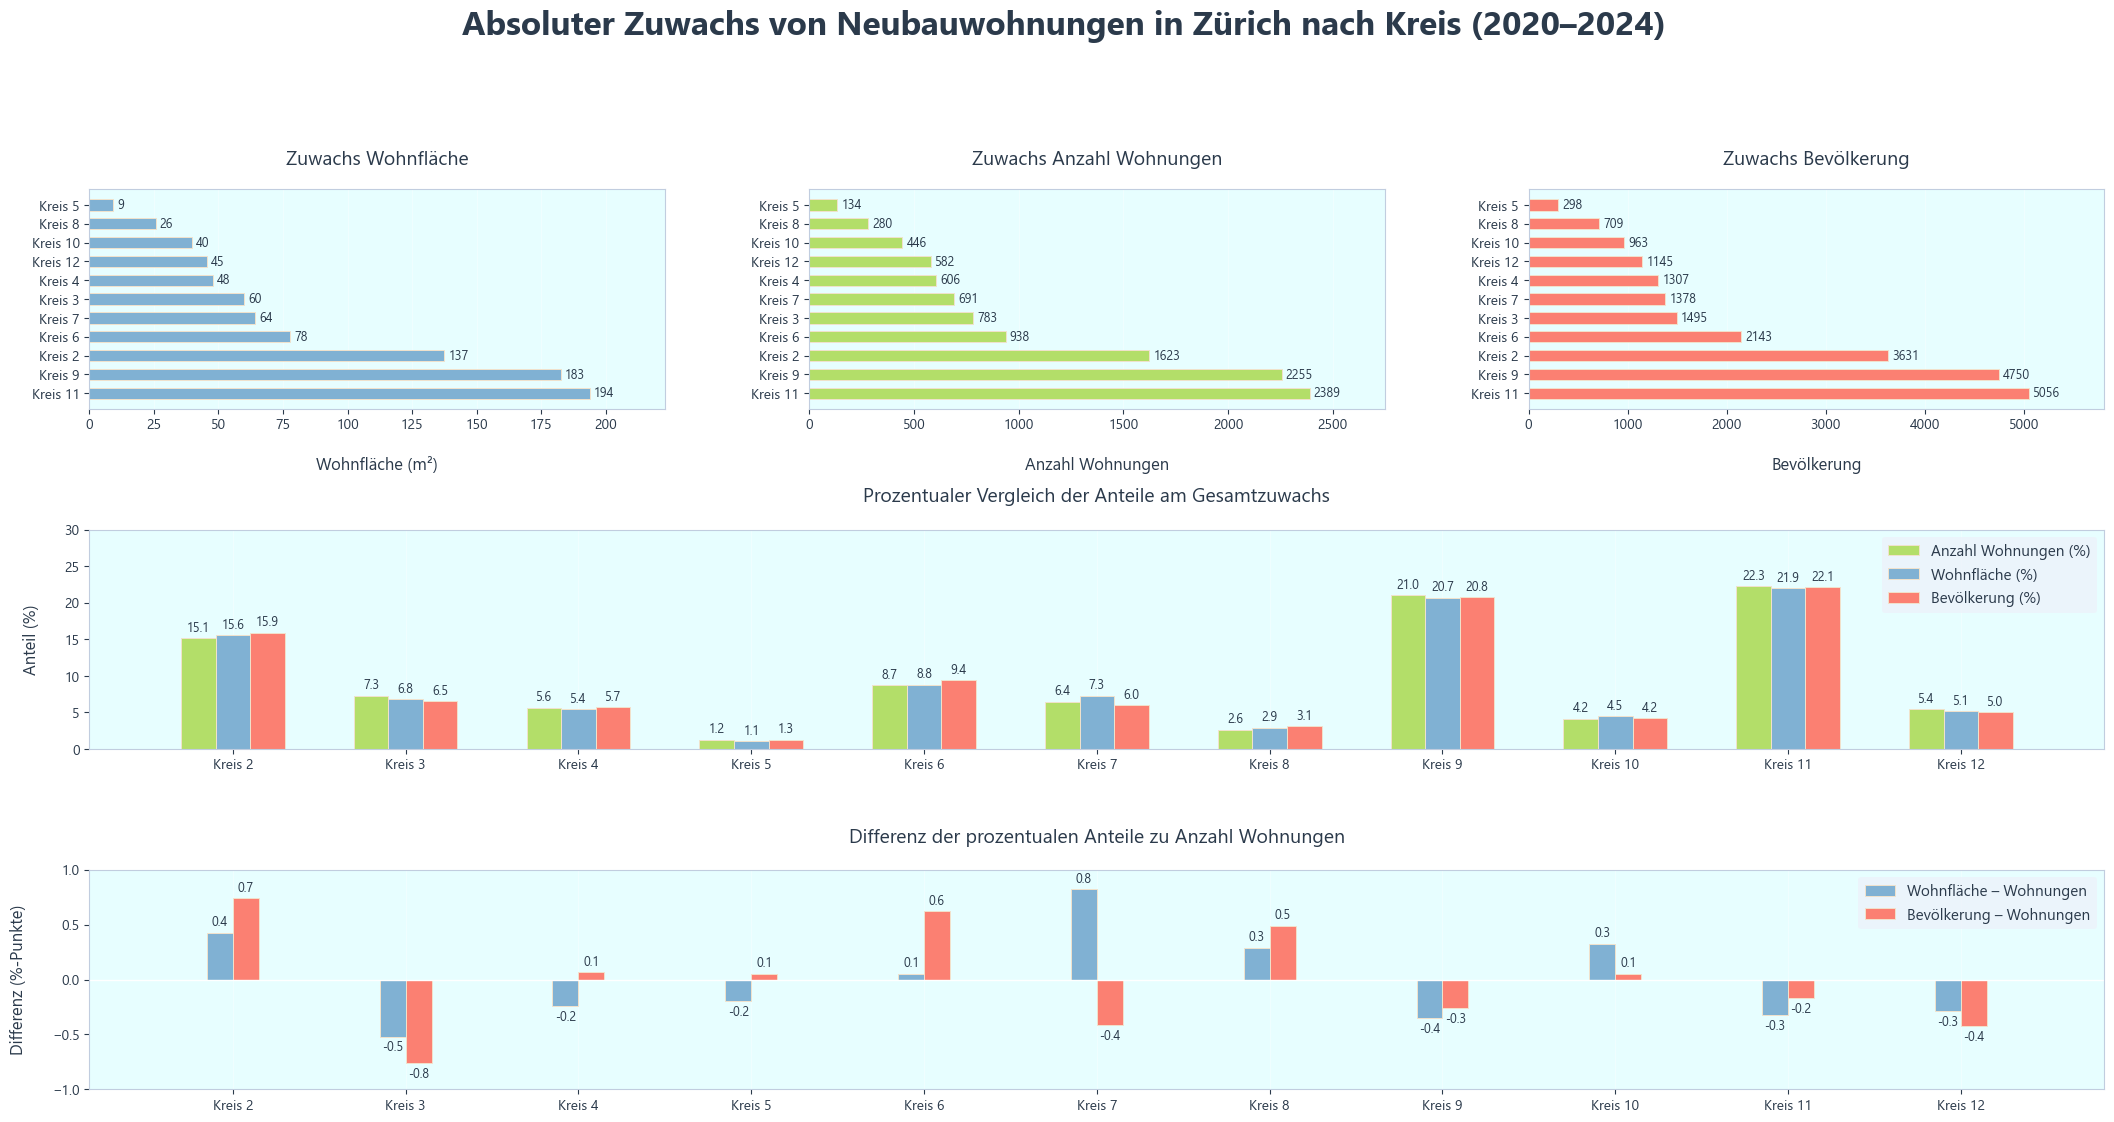

In [2281]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

# ============================================================
# Globaler Stil – Blue Harmony + professionelle Schrift
# ============================================================
plt.rcParams.update({
    "font.family": "Segoe UI",
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 11,
    "text.color": "#2B3A4B",
    "axes.labelcolor": "#2B3A4B",
    "axes.titlecolor": "#2B3A4B",
    "xtick.color": "#2B3A4B",
    "ytick.color": "#2B3A4B",
    "legend.edgecolor": "none",
})

figure_bg = "#ffffff"
axes_bg = "#e7feff"


color_living = "#80b1d3"
color_dwell  = "#b3de69"
color_pop    = "#fb8072"

edge_color   = "#f1e2cc"
grid_color   = "#ffffff"

# ============================================================
# Datenvorbereitung
# ============================================================
filtered = joined_df[joined_df["five_year_period"] == "2020–2024"]

df_3 = filtered[
    ["district_name", "living_area", "num_dwellings",
     "population_total", "five_year_period"]
].copy()

df_3["district_nr"] = df_3["district_name"].str.extract(r"Kreis (\d+)").astype(int)
df_3 = df_3.sort_values("district_nr")

# Basis-Achsenreihenfolge (für Prozent- und Differenzplots)
x = df_3["district_name"]

# Absolute Werte
living_abs    = df_3["living_area"] / 1000
dwellings_abs = df_3["num_dwellings"]
pop_abs       = df_3["population_total"]

# ============================================================
# Sortierte Daten für die oberen 3 Diagramme
# ============================================================

# Wohnfläche sortiert
df_living_sorted = df_3.sort_values("living_area", ascending=False)
x1 = df_living_sorted["district_name"]
living_abs_sorted = df_living_sorted["living_area"] / 1000

# Anzahl Wohnungen sortiert
df_dwell_sorted = df_3.sort_values("num_dwellings", ascending=False)
x2 = df_dwell_sorted["district_name"]
dwellings_abs_sorted = df_dwell_sorted["num_dwellings"]

# Bevölkerung sortiert
df_pop_sorted = df_3.sort_values("population_total", ascending=False)
x3 = df_pop_sorted["district_name"]
pop_abs_sorted = df_pop_sorted["population_total"]

# ============================================================
# Figure Setup
# ============================================================
fig1 = plt.figure(figsize=(26, 12))
fig1.patch.set_facecolor(figure_bg)

fig1.suptitle(
    "Absoluter Zuwachs von Neubauwohnungen in Zürich nach Kreis (2020–2024)",
    fontsize=24,
    fontweight="bold",
    y=1.01
)

# 3 Plot-Reihen
gs = gridspec.GridSpec(3, 3, figure=fig1)

ax_abs4 = fig1.add_subplot(gs[1, :])     # Prozent-Plot
ax_abs1 = fig1.add_subplot(gs[0, 0])     
ax_abs2 = fig1.add_subplot(gs[0, 1])
ax_abs3 = fig1.add_subplot(gs[0, 2])

ax_diff = fig1.add_subplot(gs[2, :], sharex=ax_abs4)

# ============================================================
# Helper: Achsenformat
# ============================================================
def format_axis(ax):
    ax.set_facecolor(axes_bg)
    ax.grid(axis="x", alpha=0.35, color=grid_color, linewidth=0.8)
    ax.set_axisbelow(True)
    for spine in ax.spines.values():
        spine.set_color("#C1CDDf")
        spine.set_linewidth(0.8)

# ============================================================
# Obere Plots: Horizontale Balken (links → rechts)
# ============================================================
bar_height = 0.6

# --- Wohnfläche ---
bars1 = ax_abs1.barh(
    x1, living_abs_sorted,
    bar_height,
    color=color_living, edgecolor=edge_color, linewidth=0.7
)
ax_abs1.set_title("Zuwachs Wohnfläche", pad=18)
ax_abs1.set_xlabel("Wohnfläche (m²)", labelpad=18)
ax_abs1.bar_label(bars1, padding=3, fmt="%.0f", fontsize=9)
format_axis(ax_abs1)
ax_abs1.set_xlim(0, living_abs_sorted.max() * 1.15)

# --- Anzahl Wohnungen ---
bars2 = ax_abs2.barh(
    x2, dwellings_abs_sorted,
    bar_height,
    color=color_dwell, edgecolor=edge_color, linewidth=0.7
)
ax_abs2.set_title("Zuwachs Anzahl Wohnungen", pad=18)
ax_abs2.set_xlabel("Anzahl Wohnungen", labelpad=18)
ax_abs2.bar_label(bars2, padding=3, fmt="%.0f", fontsize=9)
format_axis(ax_abs2)
ax_abs2.set_xlim(0, dwellings_abs_sorted.max() * 1.15)

# --- Bevölkerung ---
bars3 = ax_abs3.barh(
    x3, pop_abs_sorted,
    bar_height,
    color=color_pop, edgecolor=edge_color, linewidth=0.7
)
ax_abs3.set_title("Zuwachs Bevölkerung", pad=18)
ax_abs3.set_xlabel("Bevölkerung", labelpad=18)
ax_abs3.bar_label(bars3, padding=3, fmt="%.0f", fontsize=9)
format_axis(ax_abs3)
ax_abs3.set_xlim(0, pop_abs_sorted.max() * 1.15)

# ============================================================
# Prozentwerte – Reihenfolge: Wohnungen – Wohnfläche – Bevölkerung
# ============================================================
y_living_pct = living_abs    / living_abs.sum()    * 100
y_dwell_pct  = dwellings_abs / dwellings_abs.sum() * 100
y_pop_pct    = pop_abs       / pop_abs.sum()       * 100

x_pos = np.arange(len(x))
bar_width_bottom = 0.2

bars_y2 = ax_abs4.bar(
    x_pos - bar_width_bottom,
    y_dwell_pct,
    bar_width_bottom,
    color=color_dwell,
    edgecolor=edge_color,
    linewidth=0.7,
    label="Anzahl Wohnungen (%)",
)

bars_y1 = ax_abs4.bar(
    x_pos,
    y_living_pct,
    bar_width_bottom,
    color=color_living,
    edgecolor=edge_color,
    linewidth=0.7,
    label="Wohnfläche (%)",
)

bars_y3 = ax_abs4.bar(
    x_pos + bar_width_bottom,
    y_pop_pct,
    bar_width_bottom,
    color=color_pop,
    edgecolor=edge_color,
    linewidth=0.7,
    label="Bevölkerung (%)",
)

ax_abs4.set_title("Prozentualer Vergleich der Anteile am Gesamtzuwachs", pad=20)
ax_abs4.set_ylabel("Anteil (%)", labelpad=18)
ax_abs4.set_xticks(x_pos)
ax_abs4.set_xticklabels(x, ha="center")

legend = ax_abs4.legend(loc="upper right", frameon=True)
legend.get_frame().set_facecolor("#EDF2FA")

ax_abs4.bar_label(bars_y2, padding=3, fmt="%.1f", fontsize=9)
ax_abs4.bar_label(bars_y1, padding=3, fmt="%.1f", fontsize=9)
ax_abs4.bar_label(bars_y3, padding=3, fmt="%.1f", fontsize=9)

format_axis(ax_abs4)
ax_abs4.set_ylim(0, 30)

# ============================================================
# Differenzen – Wohnfläche – Bevölkerung relativ zu Wohnungen
# ============================================================
diff_living = y_living_pct - y_dwell_pct
diff_pop    = y_pop_pct    - y_dwell_pct

bar_width_diff = 0.15

bars_diff_living = ax_diff.bar(
    x_pos - bar_width_diff / 2,
    diff_living,
    bar_width_diff,
    color=color_living,
    edgecolor=edge_color,
    linewidth=0.7,
    label="Wohnfläche – Wohnungen",
)

bars_diff_pop = ax_diff.bar(
    x_pos + bar_width_diff / 2,
    diff_pop,
    bar_width_diff,
    color=color_pop,
    edgecolor=edge_color,
    linewidth=0.7,
    label="Bevölkerung – Wohnungen",
)

ax_diff.set_title("Differenz der prozentualen Anteile zu Anzahl Wohnungen", pad=20)
ax_diff.set_ylabel("Differenz (%-Punkte)", labelpad=18)

ax_diff.set_xticks(x_pos)
ax_diff.set_xticklabels(x, ha="center")
ax_diff.set_ylim(-1, 1)
ax_diff.axhline(0, color=grid_color, linewidth=1)

ax_diff.bar_label(bars_diff_living, padding=3, fmt="%.1f", fontsize=9)
ax_diff.bar_label(bars_diff_pop,    padding=3, fmt="%.1f", fontsize=9)

format_axis(ax_diff)

legend_diff = ax_diff.legend(loc="upper right", frameon=True)
legend_diff.get_frame().set_facecolor("#EDF2FA")

# ============================================================
# Layout
# ============================================================
plt.subplots_adjust(hspace=0.55, wspace=0.25, top=0.86)
plt.show()
